In [173]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.cross_validation import cross_val_score, train_test_split

from patsy import dmatrices, dmatrix

from datetime import date, datetime

import mkl
import accelerate

pd.set_option('display.max_columns', None)


# Suppress annoying deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Data Import

In [174]:
train_data = pd.read_csv('train.csv', parse_dates=['DateTime'])
test_data = pd.read_csv('test.csv', parse_dates=['DateTime'])

n_train_data = len(train_data.index)

# 1 - Feature Engineering

In [195]:
# Utility functions
# From: http://stackoverflow.com/a/28688724
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('4-winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('1-spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('2-summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('3-autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('4-winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)


In [196]:
# Merge for engineering (will split later)

feature_columns = ['AnimalID', 'Name', 'DateTime', 'AnimalType', 'SexuponOutcome', 
                    'AgeuponOutcome', 'Breed', 'Color', 'OutcomeType']

train_features = train_data.loc[:, feature_columns]
test_features = test_data.loc[:, feature_columns]
data = pd.concat((train_features, test_features), ignore_index=True)

In [197]:
data['Season'] = data.DateTime.map(get_season)

data['Sex X Species'] = data.SexuponOutcome + ' ' + data.AnimalType

data['Month'] = data.DateTime.apply(lambda d: d.strftime('%m-%B'))   # 'January', 'Feburary', . . .
data['WeekDay'] = data.DateTime.apply(lambda d: d.strftime('%w-%A')) # 'Sunday', 'Monday', . . .  

In [198]:
train_data = data[:n_train_data]
test_data = data[n_train_data:]

print len(train_data.index)
print len(test_data.index)

26729
11456


# 2 - Comapring train and test data distributions

In [199]:
train_data.describe()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeType,Season,Sex X Species,Month,WeekDay
count,26729,19038,26729,26729,26728,26711,26729,26729,26729,26729,26728,26729,26729
unique,26729,6374,22918,2,5,44,1380,366,5,4,10,12,7
top,A705677,Max,2015-08-11 00:00:00,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White,Adoption,3-autumn,Neutered Male Dog,10-October,6-Saturday
freq,1,136,19,15595,9779,3969,8810,2824,10769,7777,6714,2881,4348
first,NaN,NaN,2013-10-01 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-02-21 19:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
# Function to plot bar charts of categorical variables, with 
# train and test bars side-by-side. Hard-coded to use data from global env
def barplot_testvtrain(field_name):
    train_size = len(train_data.index) * 1.0
    test_size = len(test_data.index) * 1.0

    train_dist = train_data.groupby(field_name).size() / train_size
    test_dist = test_data.groupby(field_name).size() / test_size
    
    indices = np.arange(train_dist.size)
    width = .35
    
    fig, ax = plt.subplots()
    plt.title('{} distribution'.format(field_name))
    
    train_rects = ax.bar(indices, train_dist, width, color='r')
    test_rects = ax.bar(indices + width, test_dist, width, color='b')

    ax.set_xticks(indices + width)
    ax.set_xticklabels(train_dist.index, rotation=45)

    ax.legend((train_rects[0], test_rects[0]), ('Train', 'Test'), loc=0)
    plt.show()

In [201]:
# Function to generate stacked bar charts of outcome v. categorical variable,
# hard-coded to use data from global env
def barplot_stacked(field_name):
    # Making a copy of the data to use for plotting.
    # Copy is needed 'cuz I'm dropping NAs.
    plot_data = pd.DataFrame()
    plot_data[field_name] = train_data[field_name]
    plot_data['OutcomeType'] = train_data.OutcomeType
    plot_data = plot_data.dropna()

    # List of outcomes in order to stack, together with assigned color
    outcomes = [('Adoption', 'r'), 
                ('Transfer', 'b'), 
                ('Return_to_owner', 'g'), 
                ('Euthanasia', 'y'), 
                ('Died', 'm')]

    # Getting information about the categories in the variable
    categories = plot_data[field_name].unique()
    categories.sort()
    cat_counts = plot_data.groupby(field_name).size()
    indices = np.arange(categories.size)
    
    width = .75
    barsets = []
    
    # Series of 0s for all categories, added to distributions
    # to ensure that there's an entry for every category.
    zero = pd.Series({c:0 for c in categories})
    # Keeps track of bottoms. Bottoms are just top of previous one.
    bottoms = pd.Series({c:0 for c in categories})

    fig, ax = plt.subplots()
    plt.title('Outcomes by {}'.format(field_name))

    # Loop over outcomes, generate bars, and stack them
    for outcome, c in outcomes:
        dist = plot_data.loc[plot_data.OutcomeType == outcome] \
                         .groupby(field_name) \
                         .size() \
                         / cat_counts
                    
        dist = zero.add(dist, 'index', fill_value=0.0)

        # Saving barset for later because it's needed to draw the legend
        bs = ax.bar(indices, dist, width, color=c, bottom = bottoms)
        barsets.append(bs)
        
        # The bottom of the next round of bars will be the top of this one.
        bottoms = bottoms.add(dist, 'index', fill_value=0.0)

    # Drawing category labels
    ax.set_xticks(indices + (width / 2))
    ax.set_xticklabels(categories, rotation=90)

    # Drawing legend outside of plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend([bs[0] for bs in barsets], 
              [n[0] for n in outcomes], 
              loc='center left', 
              bbox_to_anchor=(1, 0.5))
    
    plt.show()

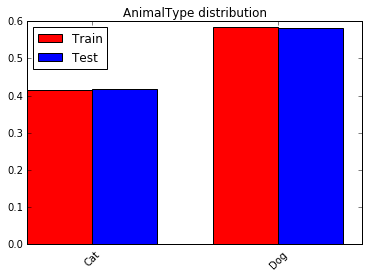

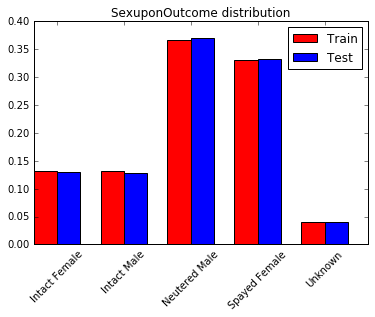

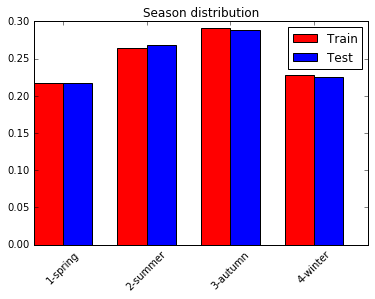

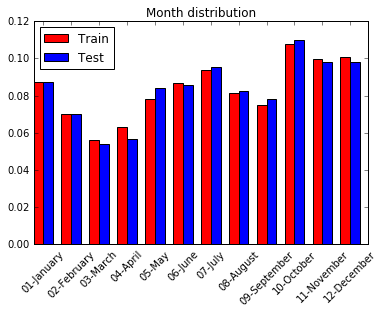

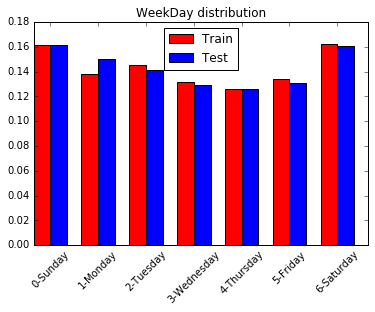

In [202]:
barplot_testvtrain('AnimalType')
barplot_testvtrain('SexuponOutcome')
barplot_testvtrain('Season')
barplot_testvtrain('Month')
barplot_testvtrain('WeekDay')

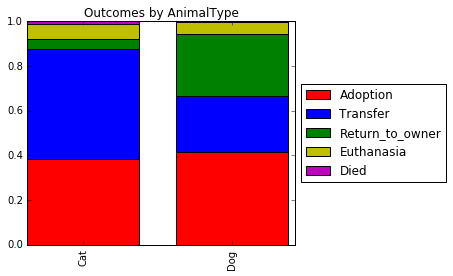

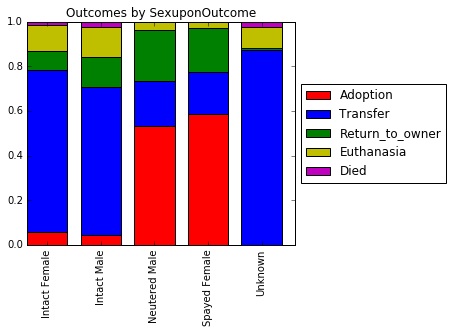

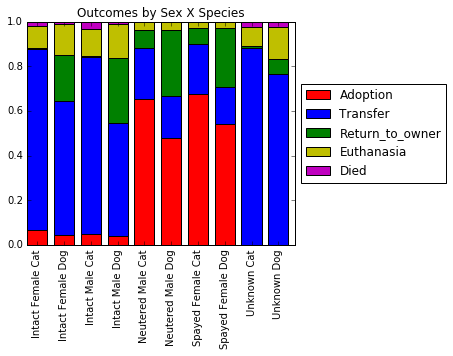

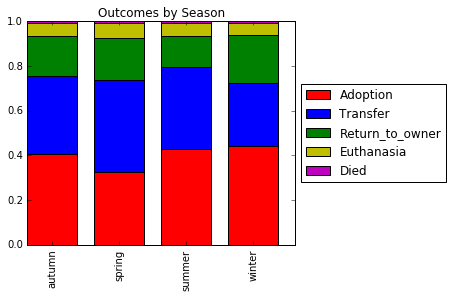

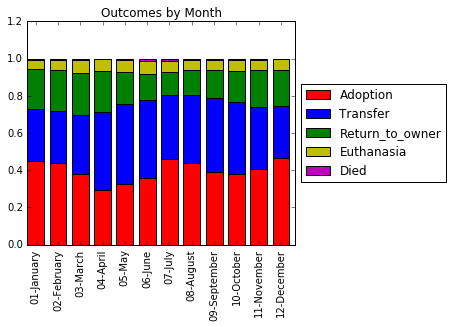

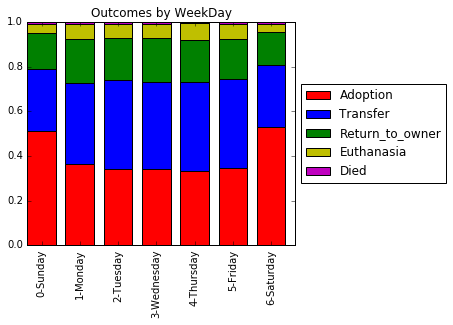

In [194]:
barplot_stacked('AnimalType')
barplot_stacked('SexuponOutcome')
barplot_stacked('Sex X Species')
barplot_stacked('Season')
barplot_stacked('Month')
barplot_stacked('WeekDay')